# Building an effective CASCI Hamiltonian with Openfermion and PySCF


I describe how to build a frozen core Hamiltonian in practice. 
We start from the original shape of the second quantized electronic Hamiltonian
\begin{equation}
\mathcal{\hat{H}}  = \sum_{pq}^{N_{MOs}} h_{pq}  \hat{E}_{pq} + \dfrac{1}{2} \sum_{pqrs}^{N_{MOs}} g_{pqrs}  \hat{e}_{pqrs}.
\label{eq:Ham_elec_}
\end{equation}
With the spin-free excitation operators
$$ \hat{E}_{pq} = \sum_\sigma a^\dagger_{p,\sigma} a_{q,\sigma}$$

Two-body excitation operator
$$ \hat{e}_{pqrs} = \hat{E}_{pq} \hat{E}_{rs} - \delta_{rq} \hat{E}_{ps} $$

Applying the frozen core approximation to this Hamiltonian consists in assuming the existence of a set of frozen orbitals (always occupied), another set of active orbitals (belonging to an active space), and a set of virtual orbitals (always unoccupied). 
Based on this partitioning, every Slater determinant $|\Phi\rangle$ used to describe properties of the system will always take the form 
\begin{equation}
    |\Phi\rangle = | \Phi_\text{frozen}\Phi_\text{active} \rangle,
    \label{eq:state}
\end{equation}

where the left contribution $\Phi_{\rm frozen}$ represents a part of the determinant encoding the frozen orbitals of the system (always occupied) whereas $\Phi_{\rm AS}$ is a part encoding the occupancy of the remaining electrons in the active orbitals of the system. 
Thus, if one considers that every correlated electronic wavefunction is always expanding in terms of Slater determinants following Eq.(\ref{eq:state}), one can demonstrate by projections onto Eq.(\ref{eq:Ham_elec_}) that the system Hamiltonian takes an effective form 
\begin{eqnarray}\label{eq:Ham_elec}
\langle\Phi| \mathcal{\hat{H}} | \Phi \rangle \equiv \langle \Phi_{\rm active} | \mathcal{\hat{H}}^{\rm FC} | \Phi_{\rm active} \rangle,
\end{eqnarray}

with $\mathcal{\hat{H}}^\text{FC}$ the so-called ''frozen core Hamiltonian'' defined as follows,
\begin{equation}
\mathcal{\hat{H}}^\text{FC} = \mathcal{\hat{H}}_\text{active}  + \hat{\mathcal{V}} + E_\text{frozen}^\text{MF}. 
\end{equation}

Here, $\mathcal{\hat{H}}_\text{active}$ is the Hamiltonian encoding the one- and two- body terms only acting in the active space,
\begin{equation}
\label{eq:AS_HAM}
\mathcal{\hat{H}}_\text{active} = \sum_{tu}^\text{active} h_{tu} \hat{E}_{tu} + \sum_{tuvw}^\text{active} g_{tuvw} \hat{e}_{tuvw},
\end{equation}

where $t,u,v,w$ denote active space orbitals.
The second term $E_{\rm frozen}^{\rm MF}$ is a scalar representing the mean-field-like energy obtained from the frozen orbitals,
\begin{equation}
    E_\text{frozen}^\text{MF} = 2\sum_i^\text{frozen} h_{ii} + \sum_{ij}^\text{frozen} (2g_{iijj}- g_{ijji}),
    \label{eq:shift}
\end{equation}
and the third term
\begin{equation}
\label{eq:emb}
\mathcal{\hat{V}} = \sum_{tu}^\text{active} \mathcal{V}_{tu} \hat{E}_{tu} \text{, with } \mathcal{V}_{tu} =  \sum_i^\text{frozen} (2g_{tuii}- g_{tiiu} )
\end{equation}

represents an effective one body potential which encodes the interaction of the frozen electrons with the active space electrons. To summarize, the main effect of the frozen core approximation [Eq.(\ref{eq:Ham_elec})] is first to introduce an energetic shift [Eq.(\ref{eq:shift})], and second to augment the one body term of the Hamiltonian operator [Eq.(\ref{eq:AS_HAM})] (that only lives in the active space) with an additional effective one body operator [Eq.(\ref{eq:emb})]. 

In [12]:
import sys,os
import numpy as np
import sympy
import openfermion
from openfermion import ops
import psi4
import cirq
import math as m
from scipy.optimize import minimize
from optimparallel import minimize_parallel
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm  
from openfermion import ops, InteractionOperator, get_sparse_operator, jordan_wigner, FermionOperator
from pyscf import fci
from pyscf import gto, scf, ao2mo, mcscf

np.set_printoptions(precision=1) # For nice matrix printing

## Building a CASCI Hamiltonian with Openfermion

### Here I build the spin free operator in fermionic representation 

One-body excitation operator
$$ \hat{E}_{pq} = \sum_\sigma a^\dagger_{p,\sigma} a_{q,\sigma}$$

Two-body excitation operator
$$ \hat{e}_{pqrs} = \hat{E}_{pq} \hat{E}_{rs} - \delta_{rq} \hat{E}_{ps} $$

In [ ]:
# ============================================================================================ 
# Useful fermionic operators  
# ============================================================================================
def E_( P, Q ):
    """
    >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    Function to create a fermionic singlet excitation operator : E_pq  
    >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    """
    OP = (  ops.FermionOperator('{}^ {}'.format( 2*P, 2*Q )) 
          + ops.FermionOperator('{}^ {}'.format( 2*P+1, 2*Q+1 )) )  
    
    return OP

def e_( P, Q, R, S ):
    """
    >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    Function to create a two-body excitation operator : e_pqrs
    >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    """
    OP = E_( P, Q ) * E_( R, S )
    if ( Q == R ): OP += - E_( P, S )
        
    return OP  

## RHF calculation on $H_4$ to get the systems integrals $g_{pqrs}$ and $h_{pq}$

In [13]:
r     = 1.
theta = 87.58620689655172  * m.pi/180.

XYZ_geometry =  ''' H   {0}   {1}  0.
                    H   {0}  -{1}  0.
                    H  -{0}   {1}  0.
                    H  -{0}  -{1}  0.'''.format( r*m.cos(theta/2.), r*m.sin(theta/2.) )
N_MOs  = 4
N_elec = 4 

frozen_occupied_indices = [ 0 ]
 
mol = gto.Mole()
mol.build( atom     = XYZ_geometry,  # in Angstrom
           basis    = 'STO-3G',
           symmetry = False,
           spin     = 0)
E_rep_nuc = mol.energy_nuc()  
mf = scf.RHF(mol)  
mf.kernel()

# Getting the 1- and 2-electron integrals from AO basis to MO basis
h_MO = np.einsum('pi,pq,qj->ij', mf.mo_coeff,
                 mol.intor_symmetric('int1e_kin') + mol.intor_symmetric('int1e_nuc'),
                 mf.mo_coeff) 

g_MO = ao2mo.restore('s1', ao2mo.kernel( mol, mf.mo_coeff ), N_MOs)

CASCI_solver = mcscf.CASCI( mf, 2, 2 ) 
CASCI_solver.fix_spin( ss=0 )   # <== Without this the CASCI calculation returns a Spin=2 result
E_CASCI = CASCI_solver.kernel() 

converged SCF energy = -1.77059540295997
CASCI E = -1.83861496609746  E(CI) = -0.954508724605245  S^2 = 0.0000000


## Creating the "effective" active space integrals

 
 $$h_{tu} \longrightarrow \text{ 1-electron integral in active space} $$
 
 $$g_{tuvw} \longrightarrow \text{ 2-electron integral in active space}$$ 
 
 $$ \mathcal{V}_{tu} =  \sum_i^\text{frozen} (2g_{tuii}- g_{tiiu} ) \longrightarrow \text{ Effective potential}$$

In [14]:
# 1-electron integral in the active space  
h_MO_active = ( h_MO[1:3,1:3] ).copy()

# 2-electron integral in the active space  
g_MO_active = ( g_MO[1:3,1:3,1:3,1:3] ).copy()

# Building the effective potential
V_active = np.zeros_like(h_MO_active)
for p in range(np.shape(h_MO_active)[0]):
    for q in range(np.shape(h_MO_active)[0]): 
        for i in frozen_occupied_indices: 
            p_ =  p + len(frozen_occupied_indices)
            q_ =  q + len(frozen_occupied_indices)
            V_active[p,q] += 2 * g_MO[p_,q_,i,i] - g_MO[p_,i,i,q_]

## Creating the meanfield contribution

\begin{equation}
    E_\text{frozen}^\text{MF} = 2\sum_i^\text{frozen} h_{ii} + \sum_{ij}^\text{frozen} (2g_{iijj}- g_{ijji}), 
\end{equation}

In [15]:
E_core_meanfield = 0
for i in frozen_occupied_indices: 
    E_core_meanfield += 2 * h_MO[i,i]
    for j in frozen_occupied_indices: 
        E_core_meanfield += 2 * g_MO[i,i,j,j] - g_MO[i,j,j,i]
        
print(" Mean-field contribution = ", E_core_meanfield)

 Mean-field contribution =  -2.9110194970631382


## Building the effective Hamiltonian with openfermion

\begin{equation} 
\mathcal{\hat{H}}^\text{FC} =    \sum_{tu}^\text{active} \tilde{h}_{tu} \hat{E}_{tu} + \sum_{tuvw}^\text{active} g_{tuvw} \hat{e}_{tuvw},
\end{equation}

With the redefinition of the active space 1-electron integrals
\begin{equation}
\tilde{h}_{tu} = h_{tu} + \mathcal{V}_{tu}
\end{equation}

### First with a fermionic representation 

In [16]:
h_MO_active = h_MO_active + V_active # <== Effective active space 1-electron integrals 

N_active_MOs = 2
Hamiltonian = ops.FermionOperator(' ') * 0
for p in range(N_active_MOs):
    for q in range(N_active_MOs):
        
        Hamiltonian +=  h_MO_active[p,q] * E_( p, q )
        
        for r in range(N_active_MOs):
            for s in range(N_active_MOs):
                
                Hamiltonian += 0.5 * g_MO_active[p,q,r,s] * e_( p, q, r, s )

Hamiltonian += E_rep_nuc + E_core_meanfield
print( Hamiltonian )

-0.8841062414922134 [] +
-0.9358274157434924 [0^ 0] +
0.22278517069324905 [0^ 0 0^ 0] +
0.22278517069324905 [0^ 0 1^ 1] +
0.21810479419508289 [0^ 0 2^ 2] +
0.21810479419508289 [0^ 0 3^ 3] +
0.04701249362311437 [0^ 2 0^ 2] +
0.04701249362311437 [0^ 2 1^ 3] +
0.04701249362311437 [0^ 2 2^ 0] +
0.04701249362311437 [0^ 2 3^ 1] +
-0.9358274157434924 [1^ 1] +
0.22278517069324905 [1^ 1 0^ 0] +
0.22278517069324905 [1^ 1 1^ 1] +
0.21810479419508289 [1^ 1 2^ 2] +
0.21810479419508289 [1^ 1 3^ 3] +
0.04701249362311437 [1^ 3 0^ 2] +
0.04701249362311437 [1^ 3 1^ 3] +
0.04701249362311437 [1^ 3 2^ 0] +
0.04701249362311437 [1^ 3 3^ 1] +
0.04701249362311437 [2^ 0 0^ 2] +
0.04701249362311437 [2^ 0 1^ 3] +
0.04701249362311437 [2^ 0 2^ 0] +
0.04701249362311437 [2^ 0 3^ 1] +
-0.90407348740611 [2^ 2] +
0.2181047941950828 [2^ 2 0^ 0] +
0.2181047941950828 [2^ 2 1^ 1] +
0.22239653467187132 [2^ 2 2^ 2] +
0.22239653467187132 [2^ 2 3^ 3] +
0.04701249362311437 [3^ 1 0^ 2] +
0.04701249362311437 [3^ 1 1^ 3] +
0.047012

### Which I transform into the qubit representation with a Jordan Wigner transformation 

\begin{equation} 
\mathcal{\hat{H}}^\text{FC}  \xrightarrow{\text{J-W}}   \sum_k h_k \mathcal{P}_k
\end{equation}

with $\mathcal{P}_k$ the so-called "Pauli-strings" stemming from the transformation

\begin{equation}
\begin{split}
     a_p \xrightarrow{\text{J-W}} \frac{1}{2}(X_p +iY_p) \bigotimes_{q=0}^{p-1} Z_l\\
    a_p^\dagger \xrightarrow{\text{J-W}} \frac{1}{2}(X_p -iY_p) \bigotimes_{q=0}^{p-1} Z_q   
\end{split}
\end{equation}


In [17]:
Hamiltonian_qubit = jordan_wigner( Hamiltonian )
print(Hamiltonian_qubit)

(-1.5730125045808547+0j) [] +
(-0.023506246811557188+0j) [X0 X1 Y2 Y3] +
(0.023506246811557188+0j) [X0 Y1 Y2 X3] +
(0.023506246811557188+0j) [Y0 X1 X2 Y3] +
(-0.023506246811557188+0j) [Y0 Y1 X2 X3] +
(0.027023742983414305+0j) [Z0] +
(0.11139258534662452+0j) [Z0 Z1] +
(0.08554615028598424+0j) [Z0 Z2] +
(0.10905239709754141+0j) [Z0 Z3] +
(0.027023742983414277+0j) [Z1] +
(0.10905239709754141+0j) [Z1 Z2] +
(0.08554615028598424+0j) [Z1 Z3] +
(0.011535414836100849+0j) [Z2] +
(0.11119826733593566+0j) [Z2 Z3] +
(0.011535414836100835+0j) [Z3]


## This Hamiltonian is associated to a matrix representation in the computational basis

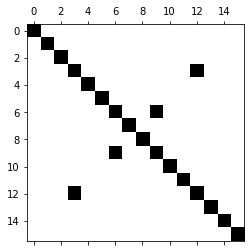

In [18]:
Hamiltonian_matrix_qubit = get_sparse_operator( Hamiltonian_qubit ).A 
 
plt.spy( Hamiltonian_matrix_qubit )
# print(Hamiltonian_matrix_qubit)

## Diagonalizing the matrix 

In [19]:
num_qubits = 4
N_elec = 2 
number_operator = ops.FermionOperator('0^ 0')
for i in range(1,num_qubits):
    number_operator += ops.FermionOperator( '{0}^ {0}'.format(i) )
    
# We build the projector onto the subspace spanning the 4 electrons fock states 
number_operator_jw     = openfermion.transforms.jordan_wigner(number_operator)
number_operator_sparse = openfermion.get_sparse_operator(number_operator_jw) 
number_operator_eig    = scipy.linalg.eigh(number_operator_sparse.A)
n_projector_basis      = number_operator_eig[1][ :,   number_operator_eig[0] == N_elec  ] 
n_projector = np.einsum('ji, ki', n_projector_basis, n_projector_basis.conjugate(), optimize=True)

S2 = openfermion.hamiltonians.s_squared_operator( n_spatial_orbitals = 2 )
S2 = get_sparse_operator( jordan_wigner(S2) ).A
S2_eig = scipy.linalg.eigh( S2 )
Singlet_projector_basis = S2_eig[1][ :, S2_eig[0] < 1e-4]
Singlet_projector = np.einsum('ji, ki', Singlet_projector_basis,
                              Singlet_projector_basis.conjugate(),
                              optimize=True)

### I compare the results of my OpenFermion Hamiltonian to PySCf native CASCI calculation

In [20]:
eigvals, eigvecs = scipy.linalg.eigh( Singlet_projector @ Hamiltonian_matrix_qubit @ Singlet_projector )

print("PySCF native CASCI calculation  :", E_CASCI[0]) 
print('Diagonalizing my OF Hamiltonian :', eigvals[0]) 

PySCF native CASCI calculation  : -1.838614966097458
Diagonalizing my OF Hamiltonian : -1.8386149660974478


## Last thing: let's build a custom quantum chemistry Hamiltonian with PySCF !

If we have electronic integrals (and Energy constants) we can build a custom quanutm chemistry Hamiltonian with PySCF and solve the latter with a FCI calculation. 

In [21]:
E_core = E_rep_nuc + E_core_meanfield 

# Introduce a new molecule instance in PySCF
mol_new = gto.Mole()
mol_new.nelectron = 2
mol_new.incore_anyway = True
N_MOs = 2

# Mean-field calculation
mf = scf.RHF( mol_new )
mf.get_hcore = lambda *args: h_MO_active         # Defining the H_core integrals
mf.get_ovlp  = lambda *args: np.eye(N_MOs)       # We set the MO overlap to identity 
mf._eri = ao2mo.restore(1, g_MO_active ,  N_MOs) # Storing the 2-electron integral
mol_new.energy_nuc = lambda *args: E_core        # We define the energy constant of the Hamiltonian  
mf.init_guess = '1e' # H_core as the guess for the Mean-field HF calculation
mf.kernel() 
 
# Full-CI resolution of the custom Hamiltonian
FCI_solver = fci.FCI( mf, mf.mo_coeff, singlet=True   ) 
E_FCI, Wfn_FCI = FCI_solver.kernel()
print("PySCF native CASCI calculation  :", E_CASCI[0]) 
print('Diagonalizing my OF Hamiltonian :', eigvals[0]) 
print('PySCF FCI energy of custom Ham  :', E_FCI )  

converged SCF energy = -1.77059540295997
PySCF native CASCI calculation  : -1.838614966097458
Diagonalizing my OF Hamiltonian : -1.8386149660974478
PySCF FCI energy of custom Ham  : -1.8386149660974578


Initialize <pyscf.gto.mole.Mole object at 0x121c22580> in <pyscf.scf.hf.RHF object at 0x121c22190>
